In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from matplotlib import pyplot as plt 
%matplotlib inline

# Based upon Andrej Walkthough for character prediction using MLP

**https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb**

In [2]:
file_path = './names.txt'
with open(file_path, 'r') as file:
    words = file.read().splitlines()

In [3]:
from typing import List, NamedTuple, Dict

class DataWrapper(NamedTuple):
    xs: torch.Tensor
    ys : torch.Tensor
    char_index: Dict[str, int]
    reverse_index: Dict[int, str]
    alphabets: List[str]

def prepare_lookup(words: List[str]):
    alphabets = list( set( ''.join(words) ) )

    char_index = { char: index + 1 for index, char in enumerate(alphabets) }
    char_index['.'] = 0
    reverse_index = { index: char for char, index in char_index.items() }

    return char_index, reverse_index, alphabets

def build_dataset(words: List[str], context_size: int = 3):
    #words = words[:5]
    
    xs, ys = [], []

    for word in words:
        #print(word)
        context = [0] * context_size
        for char in word + '.' :
            index = char_index[char]
            xs.append(context)
            ys.append(index)
            #print(context, "->", index)
            #print( ''.join(reverse_index[x] for x in context) )
            context = context[1:] + [index]

    return torch.tensor(xs), torch.tensor(ys)

import random
random.seed(42)
random.shuffle(words)
context_size = 3
char_index, reverse_index, alphabets = prepare_lookup(words)


**Create train, validation and test dataset with 80/10/10 split**

In [4]:
total_samples = len(words)
train_bound, val_bound = int(0.8 * total_samples), int(0.9 * total_samples)

x_train, y_train = build_dataset(words[:train_bound], context_size)
x_validation, y_validation = build_dataset(words[train_bound:val_bound], context_size)
x_test, y_test = build_dataset(words[val_bound:], context_size)


**Array indexing using both one-dimensional and multi-dimensional arrays.**

**Various Ways to flatten tensor from particular dimension in order to match the shape downstream.**


In [5]:
g = torch.Generator().manual_seed(1)
embedding_dim = 3
alphabet_size = len(char_index)

char_lookup = torch.rand( ( alphabet_size, embedding_dim ), generator = g )

indices = [ 0, 1, 0, 2, 0 ]
#print(char_lookup[ indices ])

# second column lookup and first column lookup
char_lookup[ indices, 1 ], char_lookup[ indices, 0 ]

# array indexing
char_lookup[ indices ].shape, char_lookup[ indices, 0:2 ]

xs = x_train
ys = y_train
print(f"Input shape: {xs.shape}, output shape: {ys.shape}")

# multidimensional indexing
embedding = char_lookup[ xs ] # embedding shape: (batch, context_size , embedding_dim )

# convert to shape (batch, context_size * embedding_dim)
# this is not scalable as addition of another embedding dimension results in code change
first_embeddings, second_embeddings, third_embeddings = (embedding[:, 0, :], embedding[:, 1, :], embedding[:, 2, :])
print(f"Shape of first embedding: {first_embeddings.shape}")

intermediate_tensors = (first_embeddings, second_embeddings, third_embeddings)
flattened_tensor = torch.cat(intermediate_tensors, dim=1)
print("Flattened tensor shape: ", flattened_tensor.shape)

# another(scalable) way to flatten tensors
unbinded_tensors = torch.unbind(embedding, dim = 1)
flattened_using_unbind = torch.cat(unbinded_tensors, dim=1)

print( "Flattened using unbind tensor shape: ", flattened_using_unbind.shape )
print( f"Both are equivalient?: {torch.equal(flattened_tensor, flattened_using_unbind)}" )

# efficent way to present view without extra tensor allocation
embedding_view = embedding.view(-1, context_size * embedding_dim )
print( f"Equivalent to above?: {torch.equal(flattened_tensor, embedding_view)}" )


Input shape: torch.Size([182625, 3]), output shape: torch.Size([182625])
Shape of first embedding: torch.Size([182625, 3])
Flattened tensor shape:  torch.Size([182625, 9])
Flattened using unbind tensor shape:  torch.Size([182625, 9])
Both are equivalient?: True
Equivalent to above?: True


**Initialize network parameters with appropriate shape**

In [73]:
hidden_units = 300
embedding = 3
char_lookup = torch.rand( ( alphabet_size, embedding_dim ), generator = g )
w1 = torch.rand( (context_size * embedding_dim, hidden_units), generator= g )
b1 = torch.rand( (hidden_units) )

w2 = torch.rand( (hidden_units, alphabet_size), generator = g )
b2 = torch.rand( alphabet_size )

print(f"H1: Weights & Bias shape: {w1.shape}, {b1.shape}")
print(f"H2: Weights & Bias shape: {w2.shape}, {b2.shape}")

parameters = [char_lookup, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters: ",  sum( p.nelement() for p in parameters ) )


H1: Weights & Bias shape: torch.Size([9, 300]), torch.Size([300])
H2: Weights & Bias shape: torch.Size([300, 27]), torch.Size([27])
Total parameters:  11208


**Learning Rate tweaks**

In [74]:
losses = []
learning_rates_buffer = []

sample_size = 64
total_iteration = 30000

linear_learning_rates = torch.linspace(0, 1, total_iteration)
exp_learning_rate_range =  torch.linspace(-3, 0, total_iteration)

exp_learning_rates = torch.pow(10, exp_learning_rate_range )

**Training Loop for the MLP**

In [77]:
for iteration in range(total_iteration):
    # reseting embedding here is required
    # otherwise ready for strange null reference error(might be due to reseting of gradient below) 

    samples_index = torch.randint(0, len(x_train), (sample_size,), generator= g)
    mini_batch = x_train[samples_index]
    
    embedding = char_lookup[mini_batch]

    # align shape of embedding and hidden layer
    # inputs to network is context_size embeddings(embeeding dimension = embedding_dim)
    embedding_view = embedding.view(-1, context_size * embedding_dim)
    h1 = torch.tanh( embedding_view @ w1 + b1)

    logits = (h1 @ w2) + b2
    # efficeint way to compute loss 
    # cross entropy will not create intermediate tensors in memory
    # instead uses fused kernels to compute efficiently all these clustered operations
    # also backward pass(refer to tanh function) might be much simpler for gradient flow.
    # Also, numerically well behaved i.e, no e^large_no = nan
    nll = F.cross_entropy(logits, y_train[samples_index] )

    reg_loss = 0.2 * ((w1**2).mean() + (w2**2).mean() ) # regularization loss

    loss = nll + reg_loss

    losses.append( loss.item())

    for p in parameters:
        p.grad = None

    loss.backward()

    #learning_rates = linear_learning_rates
    learning_rates = exp_learning_rates

    lr = 0.05 # this seems to work fine
    
    # lr = learning_rates[iteration]
    #lr = exp_learning_rates[iteration]

    learning_rates_buffer.append(lr)
    #learning_rates_buffer.append(exp_learning_rate_range[iteration])

    for p in parameters:
        p.data += -lr*p.grad

print("Final loss: ", loss.item())
#plt.figure(figsize=(10,5))
#plt.plot(learning_rates_buffer, losses)
#plt.plot(np.arange(len(losses)), losses)
#plt.plot(np.arange(len(learning_rates)), learning_rates)

#Final loss:  2.192854881286621b


Final loss:  2.2341716289520264


**Loss Validation for train, validation & test split**

In [78]:
def validation_loss(x_input: torch.Tensor, y_input: torch.Tensor, loss_message: str):

    embedding = char_lookup[x_input]

    embedding_view = embedding.view(-1, context_size * embedding_dim)
    h1 = torch.tanh( embedding_view @ w1 + b1)

    logits = (h1 @ w2) + b2
    loss = F.cross_entropy(logits, y_input )

    print(f"{loss_message}: {loss.item()}")

validation_loss(x_train, y_train, "Train loss")
validation_loss(x_validation, y_validation, "Validation loss")
validation_loss(x_test, y_test, "Test loss")

Train loss: 2.241743803024292
Validation loss: 2.24857234954834
Test loss: 2.2536461353302


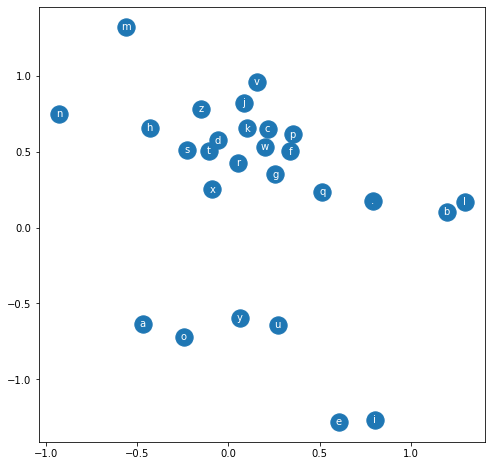

In [15]:
def visualize_embedding():
    plt.figure( figsize = (8,8) )
    plt.scatter(char_lookup[:, 0].data, char_lookup[:, 1].data, s=300)
    for i in range(char_lookup.shape[0]):
        plt.text(char_lookup[i, 0].item(), char_lookup[i, 1].item(), reverse_index[i], ha="center", va="center", color="white")

visualize_embedding()

In [42]:
def generate_name(generator: torch.Generator, context_size: int = 3):
  out = []
  context = [0] * context_size # initialize with all ...
  while True:
    emb = char_lookup[torch.tensor([context])] # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ w1 + b1)
    logits = h @ w2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator = generator).item()
    context = context[1:] + [ix]
    if ix == 0:
      break
    out.append(ix)
  return ''.join(reverse_index[i] for i in out)

g = torch.Generator().manual_seed(42)
for _ in range(20):
  print(generate_name(g))

aliwsilha
amayriszosana
ree
kajalis
tiveon
kaine
zadelaishansott
adaim
dirlya
rith
haelicleer
ghinneri
telyan
thy
kkadon
chira
anaera
khaviy
kyven
eeshin
